# Configuração do drive e do acesso ao Kaggle:

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle/"

In [3]:
# Instala o client do Kaggle para baixar o dataset
!pip uninstall -y kaggle
!pip install --upgrade pip
!pip install kaggle

Uninstalling kaggle-1.5.6:
  Successfully uninstalled kaggle-1.5.6
     |████████████████████████████████| 1.5MB 4.7MB/s 
  Found existing installation: pip 19.3.1
    Uninstalling pip-19.3.1:
      Successfully uninstalled pip-19.3.1
     |████████████████████████████████| 58 kB 2.8 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.6-py3-none-any.whl size=72859 sha256=19df13e5d355184c1ec0825506fc206399c71a6dfd3acfe89e117b900b181ff2
  Stored in directory: /root/.cache/pip/wheels/01/3e/ff/77407ebac3ef71a79b9166a8382aecf88415a0bcbe3c095a01
Successfully built kaggle


# Downloading the data from kaggle and unzipping the files:

In [4]:
!kaggle competitions download -c i2a2-brasil-pneumonia-classification

100% 1.14G/1.14G [00:10<00:00, 146MB/s]
100% 1.14G/1.14G [00:10<00:00, 113MB/s]


In [5]:
!unzip -q i2a2-brasil-pneumonia-classification.zip -d "./i2a2-brasil-pneumonia-classification/"

In [6]:
!rm i2a2-brasil-pneumonia-classification.zip

## Importing some libraries:

In [7]:
import random

import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split

from PIL import Image, ImageOps, ImageEnhance

In [8]:
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, RMSprop, SGD, Adamax
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
from tensorflow.keras.applications import DenseNet169 as BaseModel
from tensorflow.keras.applications.densenet import preprocess_input

# Loading the dataset info:

In [9]:
df_train = pd.read_csv('./i2a2-brasil-pneumonia-classification/train.csv')
df_test = pd.read_csv('./i2a2-brasil-pneumonia-classification/test.csv')

print("train:" + str(df_train.shape))
print("test:" + str(df_test.shape))

train:(4099, 2)
test:(1757, 1)


# Pre-processing:

In [10]:
df_train['pneumonia'][df_train['pneumonia'] == 0] = '0'
df_train['pneumonia'][df_train['pneumonia'] == 1] = '1'

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [11]:
# Splitting the data in training and validation:

df_train, df_valid = train_test_split(df_train, test_size=0.3, random_state=42)

In [12]:
print(df_train.shape)
print(df_valid.shape)

(2869, 2)
(1230, 2)


In [13]:
# Configuração da aumentação dos dados de treino:
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=30,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   zoom_range=0.1,
                                   horizontal_flip=False,
                                   vertical_flip=False,
                                   fill_mode='nearest')

# Configuração da aumentação dos dados de teste:
test_datagen = ImageDataGenerator(rescale=1./255)

In [14]:
images_path = './i2a2-brasil-pneumonia-classification/images/'
batch_size = 64
target_size = (512, 512)

# Criando o gerador que irá aumentar as fotos de treinamento:
train_generator = train_datagen.flow_from_dataframe(
                  dataframe=df_train,
                  directory=images_path,
                  x_col = 'fileName',
                  y_col = 'pneumonia',
                  color_mode='grayscale',
                  batch_size=batch_size,
                  target_size=target_size,
                  class_mode='binary')

# Criando o gerador que irá lidar com as fotos de validação:
valid_generator = test_datagen.flow_from_dataframe(
                  dataframe=df_valid,
                  directory=images_path,
                  x_col = 'fileName',
                  y_col = 'pneumonia',
                  color_mode='grayscale',
                  batch_size=batch_size,
                  target_size=target_size,
                  class_mode='binary')

Found 2869 validated image filenames belonging to 2 classes.
Found 1230 validated image filenames belonging to 2 classes.


# Building the model:

In [15]:
def build_model(input_shape):

    model = Sequential()
    
    model.add(Conv2D(32, (3, 3), padding='same', input_shape=input_shape))
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation = "sigmoid"))

    return model

In [16]:
model = build_model(input_shape=target_size+(1,))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 512, 512, 32)      320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 512, 512, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 256, 256, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 256, 256, 64)      18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 256, 256, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 128, 128, 128)     7

# Treinamento do modelo:

In [17]:
weights_filepath = "/content/gdrive/My Drive/Kaggle/model_weights/bpc02_simple_batch64_weights.h5"
if os.path.isfile(weights_filepath):
  # Loading best model weigths:
  model.load_weights(weights_filepath)
  print('Model weigths loaded')

Model weigths loaded


In [18]:
callbacks = [ModelCheckpoint(weights_filepath, monitor='val_acc', mode='max',
                             verbose=1, save_best_only=True),
             EarlyStopping(monitor='val_acc', mode='max', patience=10)]

# compile model:
learning_rate = 1e-4
optimizer = SGD(lr=learning_rate, momentum=0.9)
# optimizer = RMSprop(lr=learning_rate)
# optimizer = Adam(lr=learning_rate)
# optimizer = Adamax(lr=learning_rate)


model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['acc'])

In [19]:
epochs = 100
steps_per_epoch=train_generator.n//train_generator.batch_size
validation_steps=valid_generator.n//valid_generator.batch_size

model.fit(train_generator,
          steps_per_epoch=steps_per_epoch,
          epochs=epochs, callbacks=callbacks,
          validation_data=valid_generator,
          validation_steps=validation_steps)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/100
44/44 [==============================] - ETA: 0s - loss: 0.2333 - acc: 0.9159
Epoch 00001: val_acc improved from -inf to 0.92352, saving model to /content/gdrive/My Drive/Kaggle/model_weights/bpc02_simple_batch64_weights.h5
44/44 [==============================] - 158s 4s/step - loss: 0.2333 - acc: 0.9159 - val_loss: 0.2027 - val_acc: 0.9235
Epoch 2/100
44/44 [==============================] - ETA: 0s - loss: 0.2379 - acc: 0.9105
Epoch 00002: val_acc improved from 0.92352 to 0.92516, saving model to /content/gdrive/My Drive/Kaggle/model_weights/bpc02_simple_batch64_weights.h5
44/44 [==============================] - 157s 4s/step - loss: 0.2379 - acc: 0.9105 - val_loss: 0.2069 - val_acc: 0.9252
Epoch 3/100
44/44 [==============================] - ETA: 0s - loss: 0.2324 - acc: 0.9137
Epoch 00003: val_acc improved from 0.92516 to 0.92599, saving model to /content/gdrive/My Drive/Kaggle/model_weights/bp

In [20]:
model_hist = pd.DataFrame(model.history.history)
model_hist.head()

,loss,acc,val_loss,val_acc
0,0.233270,0.915865,0.202716,0.923520
1,0.237931,0.910517,0.206872,0.925164
2,0.232352,0.913725,0.206547,0.925987
3,0.233329,0.908378,0.207761,0.930921
4,0.218298,0.915865,0.211814,0.923520


In [21]:
def plot_model_hist(historic,fig1_metric='loss', fig2_metric='acc', title=''):

    plt.figure(figsize=(15, 5))

    plt.subplot(1,2,1)
    plt.title(f'{title} {fig1_metric}')
    plt.plot(historic[fig1_metric], label=f'train {fig1_metric}')
    plt.plot(historic[f'val_{fig1_metric}'], label=f'valid. {fig1_metric}')
    plt.grid()
    plt.legend()
    plt.xlabel("epoch")
    plt.ylabel(fig1_metric)

    plt.subplot(1,2,2)
    plt.title(f'{title} {fig2_metric}')
    plt.plot(historic[fig2_metric], label=f'train {fig2_metric}')
    plt.plot(historic[f'val_{fig2_metric}'], label=f'valid. {fig2_metric}')
    plt.grid()
    plt.legend()
    plt.xlabel("epoch")
    plt.ylabel(fig2_metric)

    plt.show()

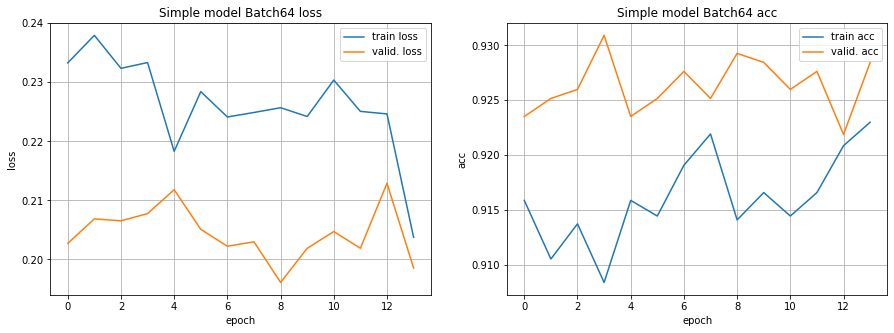

In [22]:
plot_model_hist(model_hist, title='Simple model Batch64')

# Making Predictions:

In [23]:
# Loading the saved checkpoint:
if os.path.isfile(weights_filepath):
  try:
    model.load_weights(weights_filepath)
  except ValueError:
    pass

In [24]:
# Criando o gerador que irá lidar com as fotos de teste:
test_generator = test_datagen.flow_from_dataframe(
                  dataframe=df_test,
                  directory=images_path,
                  x_col = 'fileName',
                  y_col = None,
                  color_mode='grayscale',
                  batch_size=1,
                  shuffle=False,
                  target_size=target_size,
                  class_mode=None)

Found 1757 validated image filenames.


In [25]:
filenames = test_generator.filenames
nb_samples = len(filenames)

In [26]:
test_generator.reset()
y_pred = model.predict(test_generator, steps = nb_samples, verbose=1)

predictions = []
for i in y_pred:
    if i >=0.5:
        predictions.append('1')
    else:
        predictions.append('0')

Instructions for updating:
Please use Model.predict, which supports generators.
1757/1757 [==============================] - 27s 15ms/step


In [27]:
submission = {'fileName': df_test['fileName'].values, 'pneumonia': predictions}
df_submission = pd.DataFrame(submission)
df_submission.head()

,fileName,pneumonia
0,ee9a09ba-0e24-4536-91d9-04d5f21d4056.jpeg,0
1,a46e7a54-5932-4638-8274-9df141243230.jpeg,0
2,f67d8ca6-63ea-4217-91d9-d8e9fc13094f.jpeg,0
3,da12b954-8356-45ba-a7b7-ae05659c0180.jpeg,0
4,a9e68a83-0c0f-42a5-b516-468b7a18cbe3.jpeg,0


In [28]:
df_submission.to_csv('./submission_file.csv', index=False)

# Making a submission:

In [29]:
!kaggle competitions list

ref                                            deadline             category            reward  teamCount  userHasEntered  
---------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
contradictory-my-dear-watson                   2030-07-01 23:59:00  Getting Started     Prizes         96            True  
tpu-getting-started                            2030-06-03 23:59:00  Getting Started  Knowledge        308           False  
digit-recognizer                               2030-01-01 00:00:00  Getting Started  Knowledge       2808            True  
titanic                                        2030-01-01 00:00:00  Getting Started  Knowledge      20957            True  
house-prices-advanced-regression-techniques    2030-01-01 00:00:00  Getting Started  Knowledge       5222            True  
connectx                                       2030-01-01 00:00:00  Getting Started  Knowledge        876           False  
nlp-gett

In [30]:
!kaggle competitions submit -c i2a2-brasil-pneumonia-classification -f submission_file.csv -m "Simple model Batch64"

100% 75.5k/75.5k [00:02<00:00, 27.0kB/s]
Successfully submitted to I2A2 Brasil - Pneumonia Classification